# <span style="color:blue;">**EV Adoption/Charging Forecasting**</span>
---
**Developer:** [Saaiem Salaar](https://www.linkedin.com/in/salaarsaaiem525/)


### <span style="color:red;">**1 - Import Required Libraries**</span>
- `joblib` — Used for saving and loading machine learning models efficiently.
- `numpy` — Provides support for numerical computations and multi-dimensional arrays.
- `pandas` — Used for data manipulation and analysis using DataFrames.
- `seaborn` — Statistical data visualization library built on top of matplotlib.
- `matplotlib.pyplot` — Used for creating static and interactive plots and graphs.
- `LabelEncoder` — Encodes categorical labels as numeric values.
- `RandomForestRegressor` — A regression model that uses an ensemble of decision trees.
- `train_test_split` — Splits the dataset into training and testing subsets.
- `RandomizedSearchCV` — Performs randomized hyperparameter tuning.
- `mean_absolute_error, mean_squared_error, r2_score` — Provides evaluation metrics for regression models.


In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### <span style="color:red;">**2 - Load Dataset**</span>
Dataset from Keggle: [Download](https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data)

In [3]:
# Load data
df = pd.read_csv("Dataset.csv")

### <span style="color:red;">**3 - Explore and Understand the Data**</span>

In [4]:
df.head() # top 5 rows


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [10]:
# Check Dataset Dimensions
print("Dataset Shape:", df.shape)


Dataset Shape: (20819, 10)


In [ ]:
# Data Types, class and memory alloc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

As we could see, only Percent Eletric Vehicles is numeric.

In [11]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

Missing values in County and State.

**Check if any column contain outliers.**

In [12]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


### <span style="color:red;">**4 - Data Preprocessing**</span>

Basic Data Cleaning

In [13]:
# Converts the "Date" column to actual datetime objects
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


Remove Outliers: Cap the values to the IQR bounds

In [14]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


Convert all count columns to numeric (in case they are strings)

In [15]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,2.122378
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,6.902500


Identifying counties with most number of EVs

In [16]:
# Most EVs by County
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Union         1.0
Hood River    1.0
Name: Electric Vehicle (EV) Total, dtype: float64


Sum of the vehicles in different categories

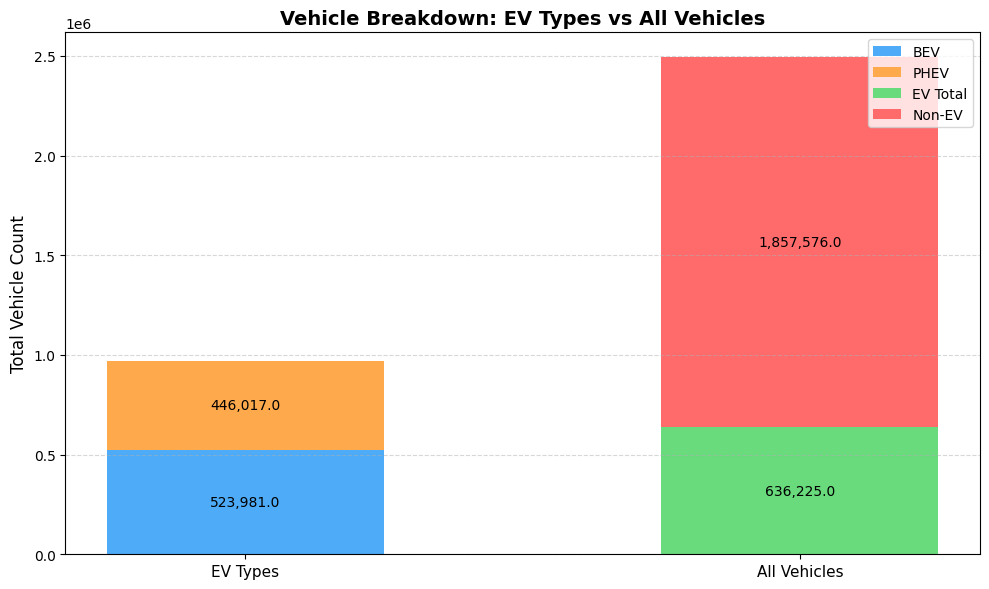

In [18]:
import matplotlib.pyplot as plt

# Calculate totals
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Bar positions
x_labels = ['EV Types', 'All Vehicles']
x_pos = [0, 1]
bar_width = 0.5

# Plot stacked bars
# EV Types breakdown
ax.bar(x_pos[0], bev_total, width=bar_width, label='BEV', color='#4dabf7')
ax.bar(x_pos[0], phev_total, width=bar_width, bottom=bev_total, label='PHEV', color='#ffa94d')

# All vehicles breakdown
ax.bar(x_pos[1], ev_total, width=bar_width, label='EV Total', color='#69db7c')
ax.bar(x_pos[1], non_ev_total, width=bar_width, bottom=ev_total, label='Non-EV', color='#ff6b6b')

# Annotate bar values
for i, (val1, val2) in enumerate([(bev_total, phev_total), (ev_total, non_ev_total)]):
    ax.text(x_pos[i], val1 / 2, f'{val1:,}', ha='center', va='center', color='black', fontsize=10)
    ax.text(x_pos[i], val1 + val2 / 2, f'{val2:,}', ha='center', va='center', color='black', fontsize=10)

# Final touches
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=11)
ax.set_ylabel('Total Vehicle Count', fontsize=12)
ax.set_title('Vehicle Breakdown: EV Types vs All Vehicles', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Feature engineering

In [19]:
# Extract year, month, and date
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month  # For trend

# Encode County
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])

# Sort for lag creation
df = df.sort_values(['County', 'Date'])

### Before creating lag features, sort by ['County', 'Date'] to ensure accuracy.

Then for each county (groupby('County')), create:

- ev_total_lag1/2/3: EV total from 1, 2, and 3 months ago

- ev_total_roll_mean_3: 3-month rolling average (smoother trend)

- ev_total_pct_change_1: Month-over-month EV growth rate

- ev_total_pct_change_3: 3-month EV growth trend (momentum)

These features help capture historical patterns and local trends per county.


In [20]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

### In time-series forecasting, past values often influence future ones. Lag features allow your model to learn trends like: "If EV count increased in the last 3 months, it’s likely to keep increasing."

These lagged values act as predictive memory of the system.

- ev_growth_slope - Trend in cumulative EV count over 6 months for early-stage EV adoption

In [22]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)
# Drop early rows with no lag data
df = df.dropna().reset_index(drop=True)
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [23]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [24]:
X.shape
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
y_test.head()

11315    1.0
11316    1.0
11317    1.0
11318    1.0
11319    1.0
Name: Electric Vehicle (EV) Total, dtype: float64

### Model Selection
Type of Problem: Regression Problem - Predicting continuous values like 'Electric Vehicle (EV) Total'

Algorithms Considered: Random Forest Regressor

Chosen Model: Random Forest for its robustness and ability to model non-linear relationships.

Model Training, Tuning and Optimization Why Tuning?

- Improves performance by finding the best model parameters.
### Techniques:

- RandomizedSearchCV for hyperparameter tuning.
- Cross-validation to avoid overfitting.

In [25]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11315,97,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11316,98,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11317,5,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11318,6,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11319,7,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0


### Model Evaluation
Evaluation Metrics:

- Mean Squared Error (MSE) – Penalizes larger errors.
- R² Score – Measures goodness of fit.

In [27]:
# Create a DataFrame with actual and predicted values

comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

# Show the first 10 rows
comparison_df.head(10)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0
9,1.0,1.0


Actual vs Predicted EV Count


📊 Model Evaluation Metrics
MAE       : 0.01
RMSE      : 0.06
R² Score  : 1.00


C:\Users\aar5e\AppData\Local\Temp\ipykernel_6048\4291683196.py:31: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\aar5e\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


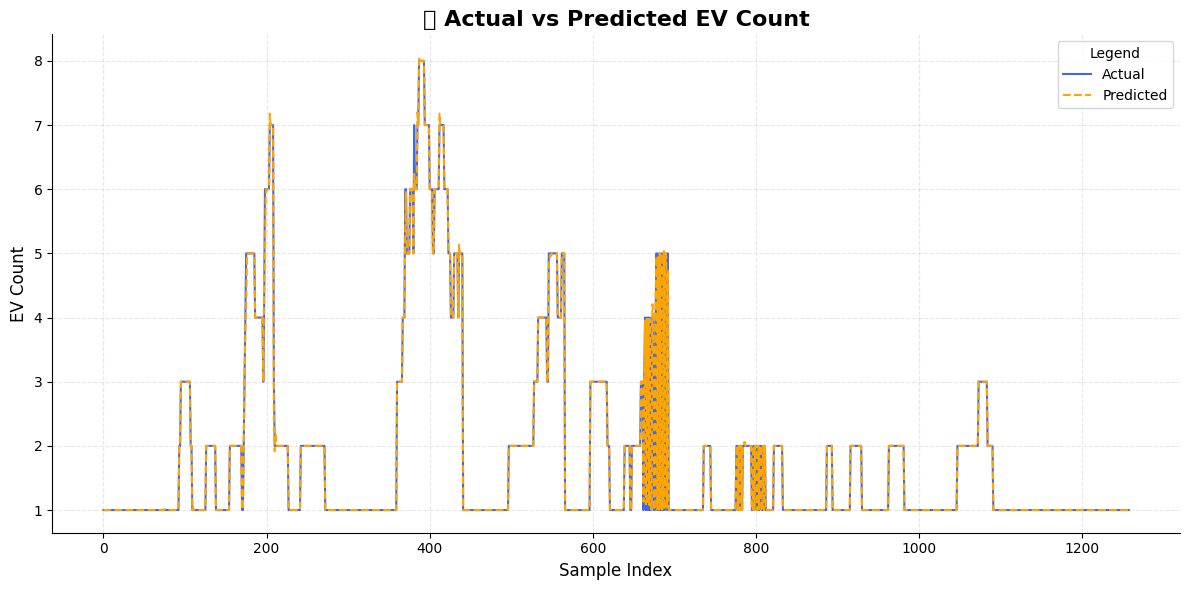

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print("\n📊 Model Evaluation Metrics")
    print("=" * 35)
    print(f"MAE       : {mae:.2f}")
    print(f"RMSE      : {rmse:.2f}")
    print(f"R² Score  : {r2:.2f}")
    print("=" * 35)

evaluate(y_test, y_pred)

# Plot Actual vs Predicted using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(y_test)), y=y_test.values, label='Actual', color='royalblue')
sns.lineplot(x=range(len(y_pred)), y=y_pred, label='Predicted', color='orange', linestyle='--')

plt.title("📈 Actual vs Predicted EV Count", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("EV Count", fontsize=12)
plt.legend(title="Legend")
sns.despine()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Get Feature Importance

C:\Users\aar5e\AppData\Local\Temp\ipykernel_6048\1782288994.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


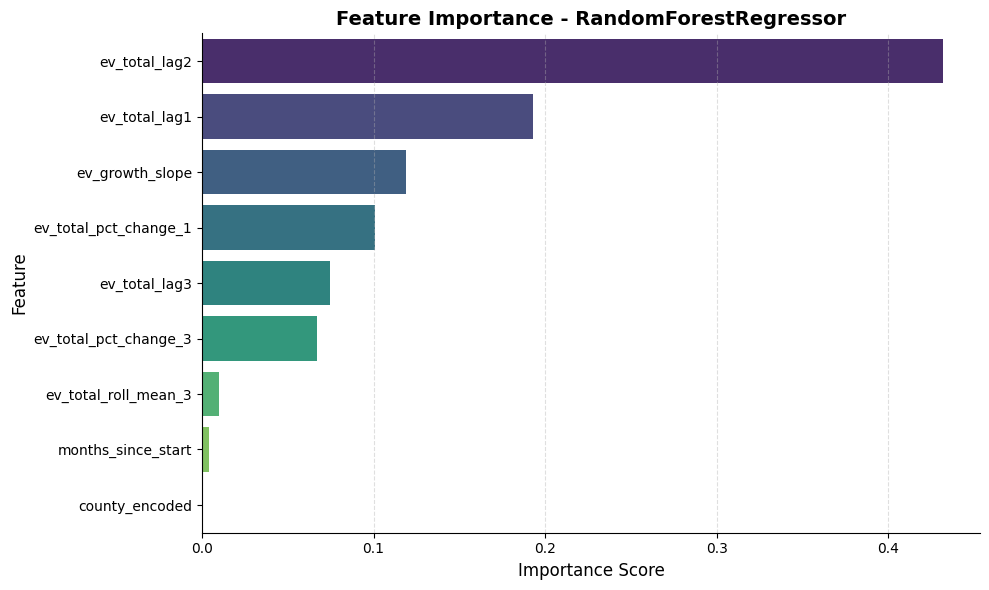

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get feature importances from RandomForestRegressor
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    palette='viridis'
)

plt.title('Feature Importance - RandomForestRegressor', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()


### Forecasting with Regression Model for Next 3 Years
Forecasting total eletric vehicles for a specific county (e.g., Clark)

In [36]:
# Define features and extract county data
featuresX = ['County', 'county_encoded']
countyX = df[featuresX]

# Display unique counties
unique_counties = df['County'].dropna().unique()

print("\n📍 List of Unique Counties:")
for county in unique_counties:
    print(f" - {county}")

print(f"\n🔢 Total Unique Counties: {df['County'].nunique()}")



📍 List of Unique Counties:
 - Ada
 - Adams
 - Alameda
 - Albemarle
 - Alexandria
 - Allegheny
 - Allen
 - Anchorage
 - Anne Arundel
 - Arapahoe
 - Arlington
 - Atlantic
 - Autauga
 - Baltimore
 - Bartow
 - Beaufort
 - Bell
 - Bergen
 - Berkeley
 - Berkshire
 - Bexar
 - Boone
 - Boulder
 - Bradley
 - Brevard
 - Broward
 - Bryan
 - Bucks
 - Burlington
 - Caddo
 - Calvert
 - Camden
 - Canyon
 - Carroll
 - Carson City
 - Cascade
 - Champaign
 - Charles
 - Charleston
 - Charlottesville
 - Chesapeake
 - Clackamas
 - Clay
 - Clinton
 - Cobb
 - Cochise
 - Collier
 - Collin
 - Columbia
 - Contra Costa
 - Cook
 - Coryell
 - Cumberland
 - Currituck
 - Dakota
 - Dale
 - Dallas
 - Dane
 - Danville
 - DeKalb
 - Denton
 - Denver
 - Deschutes
 - District of Columbia
 - Dorchester
 - Douglas
 - DuPage
 - Duval
 - Eagle
 - Eau Claire
 - El Dorado
 - El Paso
 - Escambia
 - Essex
 - Fairbanks North Star
 - Fairfax
 - Flathead
 - Fort Bend
 - Franklin
 - Frederick
 - Fresno
 - Fulton
 - Galveston
 - Garfi

County 'Kings' encoded as 130


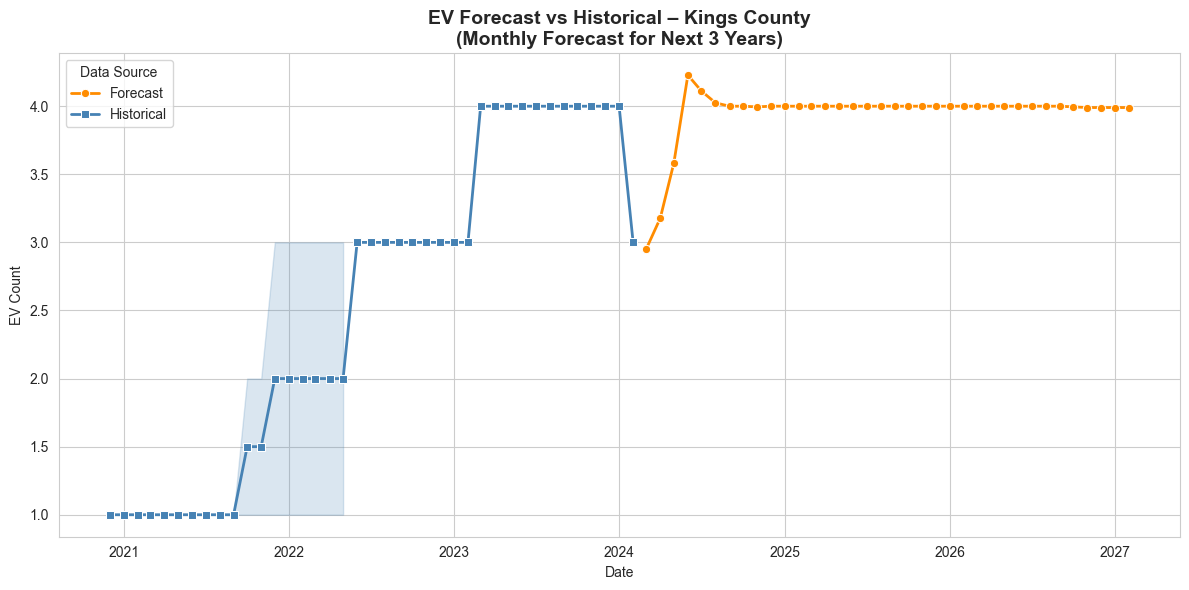

In [40]:
# Set your county name
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"⚠️ No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['months_since_start'].max()

# Create historical DataFrame
historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    # Lag features
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 else 0

    # Slope feature
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0]

    # Predict next value
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    # Update rolling history
    historical_ev.append(pred)
    historical_ev.pop(0)
    cumulative_ev.append(cumulative_ev[-1] + pred)
    cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Forecast DataFrame
forecast_df = pd.DataFrame(future_rows)

# Combine historical and forecast
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
palette = {'Historical': 'steelblue', 'Forecast': 'darkorange'}

for source, group in combined.groupby('Source'):
    sns.lineplot(x='Date', y='Electric Vehicle (EV) Total', data=group,
                 label=source, marker='o' if source == 'Forecast' else 's', linewidth=2, color=palette[source])

plt.title(f"EV Forecast vs Historical – {county} County\n(Monthly Forecast for Next 3 Years)", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.legend(title="Data Source")
plt.tight_layout()
plt.show()


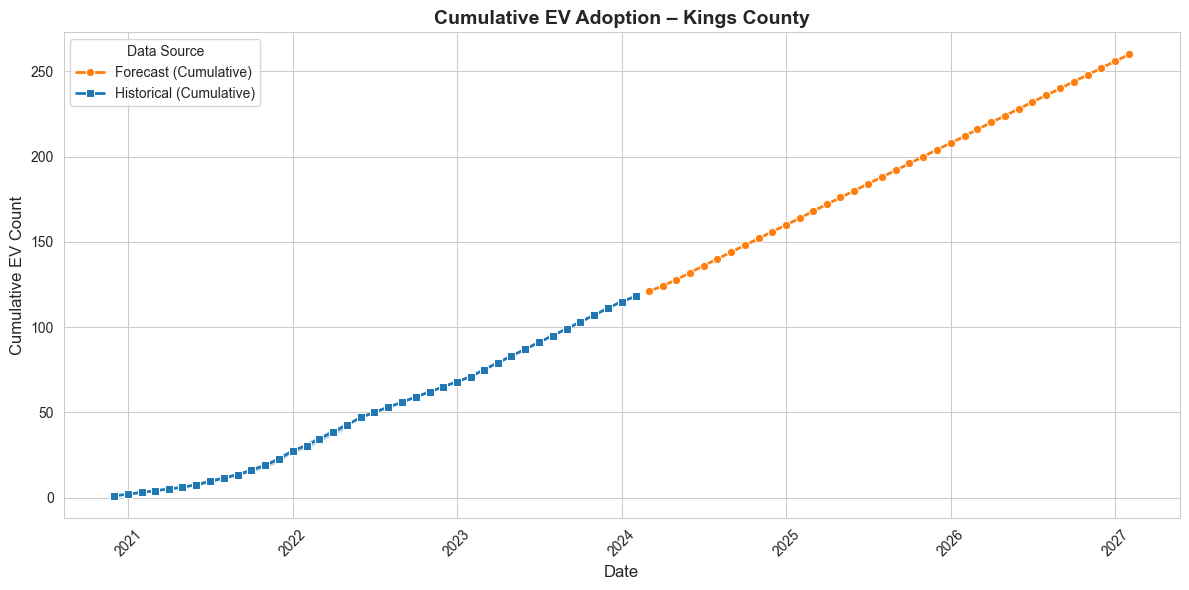

In [42]:
# --- Sort by date ---
combined = combined.sort_values("Date")

# --- Calculate cumulative EV count ---
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# --- Plot cumulative EV adoption ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
palette = {'Historical': '#1f77b4', 'Forecast': '#ff7f0e'}

for source, group in combined.groupby('Source'):
    sns.lineplot(
        x='Date',
        y='Cumulative EVs',
        data=group,
        label=f"{source} (Cumulative)",
        marker='o' if source == 'Forecast' else 's',
        linewidth=2,
        color=palette[source]
    )

plt.title(f"Cumulative EV Adoption – {county} County", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative EV Count", fontsize=12)
plt.legend(title="Data Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Forecasting for Top-5 Counties

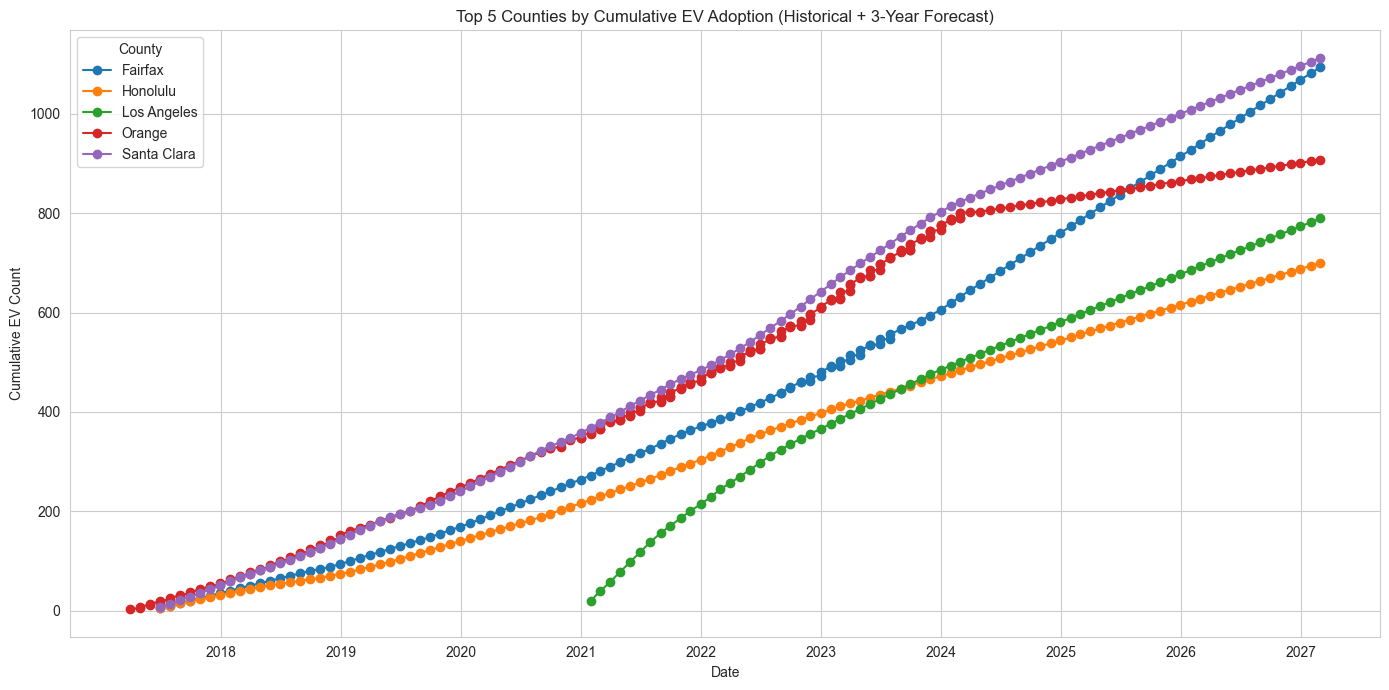

In [45]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

The graph compares the historical and projected cumulative electric vehicle (EV) adoption trends for the top 5 U.S. counties—Santa Clara, Fairfax, Orange, Honolulu, and Los Angeles—from around 2017 to 2027.

## **Final Model Testing and Save the Model**

In [47]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")
# Make predictions
# Test prediction on new or existing sample
sample = X_test.iloc[[0]]  # use one row as test
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\nTesting saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")

Model saved to 'forecasting_ev_model.pkl'
Model loaded successfully.

Testing saved model on 1 sample:
Actual EVs: 1.00, Predicted EVs: 1.00
